$$
\newcommand{\mat}[1]{\boldsymbol {#1}}
\newcommand{\mattr}[1]{\boldsymbol {#1}^\top}
\newcommand{\matinv}[1]{\boldsymbol {#1}^{-1}}
\newcommand{\vec}[1]{\boldsymbol {#1}}
\newcommand{\vectr}[1]{\boldsymbol {#1}^\top}
\newcommand{\rvar}[1]{\mathrm {#1}}
\newcommand{\rvec}[1]{\boldsymbol{\mathrm{#1}}}
\newcommand{\diag}{\mathop{\mathrm {diag}}}
\newcommand{\set}[1]{\mathbb {#1}}
\newcommand{\cset}[1]{\mathcal{#1}}
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\newcommand{\pderiv}[2]{\frac{\partial #1}{\partial #2}}
\newcommand{\bb}[1]{\boldsymbol{#1}}
\newcommand{\E}[2][]{\mathbb{E}_{#1}\left[#2\right]}
\newcommand{\ip}[3]{\left<#1,#2\right>_{#3}}
\newcommand{\given}[]{\,\middle\vert\,}
\newcommand{\DKL}[2]{\cset{D}_{\text{KL}}\left(#1\,\Vert\, #2\right)}
\newcommand{\grad}[]{\nabla}
$$

# Part 3: Mini-Project
<a id=part3></a>

In this part you'll implement a small comparative-analysis project, heavily based on the materials from the tutorials and homework.

You must **choose one** of the project options specified below.

### Guidelines

- You should implement the code which displays your results in this notebook, and add any additional code files for your implementation in the `project/` directory. You can import these files here, as we do for the homeworks.
- Running this notebook should not perform any training - load your results from some output files and display them here. The notebook must be runnable from start to end without errors.
- You must include a detailed write-up (in the notebook) of what you implemented and how. 
- Explain the structure of your code and how to run it to reproduce your results.
- Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework.
- Analyze your numerical results, explaining **why** you got these results (not just specifying the results).
- Where relevant, place all results in a table or display them using a graph.
- Before submitting, make sure all files which are required to run this notebook are included in the generated submission zip.
- Try to keep the submission file size under 10MB. Do not include model checkpoint files, dataset files, or any other non-essentials files. Instead include your results as images/text files/pickles/etc, and load them for display in this notebook. 

## Spectrally-Normalized Wasserstein GANs

In HW3 we implemented a simple GANs from scratch, using an approach very similar to the original GAN paper. However, the results left much to be desired and we discovered first-hand how hard it is to train GANs due to their inherent instability.

One of the prevailing approaches for improving training stability for GANs is to use a technique called [Spectral Normalization](https://arxiv.org/pdf/1802.05957.pdf) to normalize the largest singular value of a weight matrix so that it equals 1.
This approach is generally applied to the discriminator's weights in order to stabilize training. The resulting model is sometimes referred to as a SN-GAN.
See Appendix A in the linked paper for the exact algorithm. You can also use pytorch's `spectral_norm`.

Another very common improvement to the vanilla GAN is known a [Wasserstein GAN](https://arxiv.org/pdf/1701.07875.pdf) (WGAN). It uses a simple modification to the loss function, with strong theoretical justifications based on the Wasserstein (earth-mover's) distance.
See also [here](https://developers.google.com/machine-learning/gan/loss) for a brief explanation of this loss function.

One problem with generative models for images is that it's difficult to objectively assess the quality of the resulting images.
To also obtain a quantitative score for the images generated by each model,
we'll use the [Inception Score](https://arxiv.org/pdf/1606.03498.pdf).
This uses a pre-trained Inception CNN model on the generated images and computes a score based on the predicted probability for each class.
Although not a perfect proxy for subjective quality, it's commonly used a way to compare generative models.
You can use an implementation of this score that you find online, e.g. [this one](https://github.com/sbarratt/inception-score-pytorch) or implement it yourself.

Based on the linked papers, add Spectral Normalization and the Wassertein loss to your GAN from HW3.
Compare between:
- The baseline model (vanilla GAN)
- SN-GAN (vanilla + Spectral Normalization)
- WGAN (using Wasserstein Loss)
- Optional: SN+WGAN, i.e. a combined model using both modifications.

As a dataset, you can use [LFW](http://vis-www.cs.umass.edu/lfw/) as in HW3 or [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html), or even choose a custom dataset (note that there's a dataloder for CelebA in `torchvision`). 

Your results should include:
- Everything written in the **Guidelines** above.
- A comparative analysis between the baseline and the other models. Compare:
  - Subjective quality (show multiple generated images from each model)
  - Inception score (can use a subset of the data).
- You should show substantially improved subjective visual results with these techniques.

## Spectrally-Normalized Wasserstein GANs IMPLEMENTATION

**Explaination of the structure of the code and how to run it to reproduce your results**

we have the following files under project dir:

    1. autoencoder - taken from hw3.
    2. plot_graphs - helper funcs to plot graphs.
    3. score_inception - implementation of inception score based on web .
    4. vanilla gan - vanilla gan implementation based on HW3.
    5. spectral norm gan - implementation of the net using spectral norm based on papers.
    6. wass gan - implementation of the net using wass loss based on the paper.
    7. spectral norm + wass gan - implementation of the net using spectral norm and wass loss.
    8. train gan model - implementation of training methods similar to previews HWs.
 
we have the following sub-directory:

    1. project/output_for_graphs
    2. project/generated_imgs

During the train stage, we export the results for each epoch (discriminator loss, generator loss, inception score) into a text file.
Later on, when we want to plot the graphs, we reach out to the necessary text files and import the data for the graphical representation

**Reproducing the results**

For getting the results it's enough to just run this note book, that will create temp files under project/output_for_graphs and then you can see the results on graph in the notebook itself.


**Explicitly state any external code you used, including built-in pytorch models and code from the course tutorials/homework:**

In the top of every file in our project we explicitly stated any external code we used and other origins we found helpful for understanding how we wish to implement.


In [1]:
# import labbrys
import unittest
import os
import sys
import pathlib
import urllib
import shutil
import re
import zipfile

import numpy as np
import torch
import matplotlib.pyplot as plt

import cs236781.plot as plot
import cs236781.download

In [2]:
"""create file for the checkpoint and images, we will save the resoult there"""

if not os.path.exists('checkpoints'):
    os.makedirs('checkpoints')
if not os.path.exists('project/generated_imgs'):
    os.makedirs('project/generated_imgs')

In [3]:
"""load the data """

import torchvision.transforms as T
from torchvision.datasets import ImageFolder

#load device.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUSTOM_DATA_URL = None
DATA_DIR = pathlib.Path.home().joinpath('.pytorch-datasets')
if CUSTOM_DATA_URL is None:
    DATA_URL = 'http://vis-www.cs.umass.edu/lfw/lfw-bush.zip'
else:
    DATA_URL = CUSTOM_DATA_URL

# download data
_, dataset_dir = cs236781.download.download_data(out_path=DATA_DIR, url=DATA_URL, extract=True, force=False)


im_size = 64
tf = T.Compose([
    # Resize to constant spatial dimensions
    T.Resize((im_size, im_size)),
    # PIL.Image -> torch.Tensor
    T.ToTensor(),
    # Dynamic range [0,1] -> [-1, 1]
    T.Normalize(mean=(.5,.5,.5), std=(.5,.5,.5)),
])

ds_gwb = ImageFolder(os.path.dirname(dataset_dir), tf)
print("we working on device: ", device)
print("\n##################################")

File /home/topaz.aharon/.pytorch-datasets/lfw-bush.zip exists, skipping download.
Extracting /home/topaz.aharon/.pytorch-datasets/lfw-bush.zip...
Extracted 531 to /home/topaz.aharon/.pytorch-datasets/lfw/George_W_Bush
we working on device:  cuda

##################################


In [4]:
# from project.train_gan_model import train_gan_model
# from  project.answers import *

from project.train_gan_model import *
from project.score_inception import inception_score
from project.plot_graphs import *

In [5]:
import project.vanilla_gan as v_gan
v_gen = train_gan_model(device, ds_gwb, v_gan, 'v_gan', v_gan_hyperparams())

##inception score
# mean , scores = inception_score(v_gen, cuda=True, batch_size=32, resize=False, splits=1)
# print(f'$$$$$$$$$$$$$$$ scores are {scores} and mean score is{mean}.')

<class 'torch.device'>
{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.0075}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.001, 'betas': (0.5, 0.999)}}
<module 'project.vanilla_gan' from '/home/topaz.aharon/DL/hw4/project/vanilla_gan.py'>
 EPOCH 1/100 
100%|██████████| 17/17 [00:03<00:00,  4.38it/s]
discriminator loss - 15.882043838500977
generator loss     - 15.64831774273398


/home/topaz.aharon/miniconda3/envs/cs236781-hw/lib/python3.8/site-packages/torch/nn/functional.py:3118: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn("Default upsampling behavior when mode={} is changed "
/home/topaz.aharon/DL/hw4/project/score_inception.py:45: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


 EPOCH 2/100 
100%|██████████| 17/17 [00:03<00:00,  4.67it/s]
discriminator loss - 9.020112184040686
generator loss     - 17.34306713862016
 EPOCH 3/100 
100%|██████████| 17/17 [00:03<00:00,  4.70it/s]
discriminator loss - 2.7975719437441406
generator loss     - 21.043421790880316
 EPOCH 4/100 
100%|██████████| 17/17 [00:03<00:00,  4.75it/s]
discriminator loss - 17.805477142333984
generator loss     - 14.922973856744674
 EPOCH 5/100 
100%|██████████| 17/17 [00:03<00:00,  4.60it/s]
discriminator loss - 16.767984614652747
generator loss     - 17.585670262233435
 EPOCH 6/100 
100%|██████████| 17/17 [00:03<00:00,  4.69it/s]
discriminator loss - 8.348191109650275
generator loss     - 20.00978376590544
 EPOCH 7/100 
100%|██████████| 17/17 [00:03<00:00,  4.68it/s]
discriminator loss - 17.890515888438504
generator loss     - 18.958174501554126
 EPOCH 8/100 
100%|██████████| 17/17 [00:03<00:00,  4.55it/s]
discriminator loss - 11.203153189490823
generator loss     - 21.364343207943453
 EPOCH 9/1

*** Images Generated from best model:


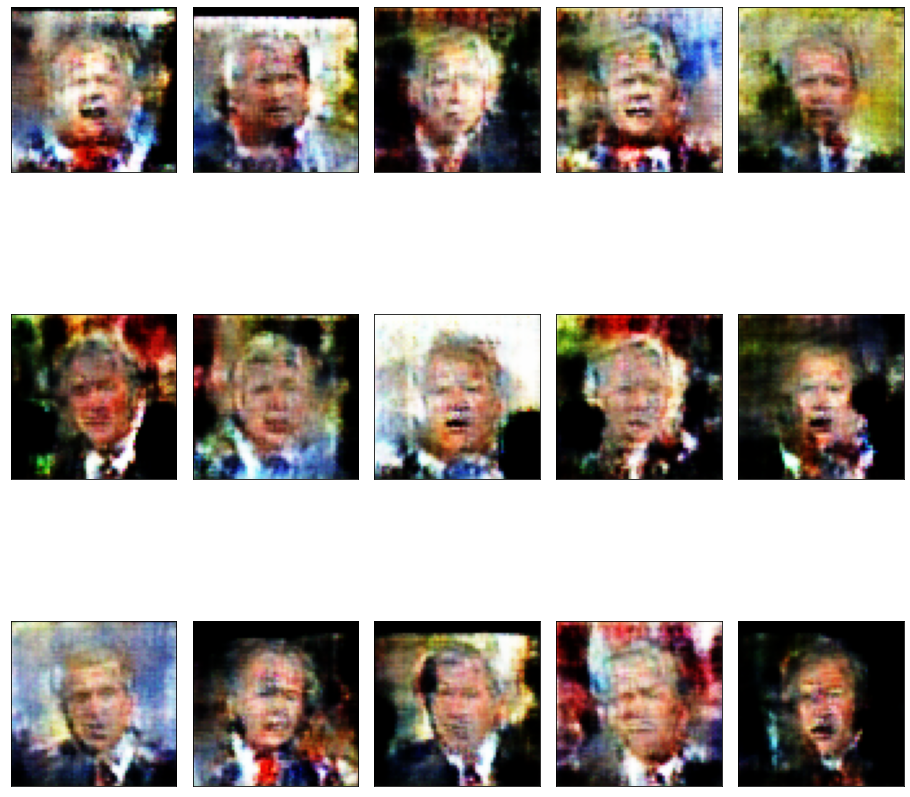

In [6]:
# Plot images from best or last model
checkpoint_file = 'checkpoints/v_gan'
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(16,16))

first_file lines: [15.882043838500977, 9.020112184040686, 2.7975719437441406, 17.805477142333984, 16.767984614652747, 8.348191109650275, 17.890515888438504, 11.203153189490823, 6.8003788581665825, 2.9710713578935932, 9.38583594692104, 16.941197956309598, 16.073044552522546, 16.085981509264776, 15.48195652400746, 14.320079438826617, 10.305709247203435, 15.996651593376608, 16.015514766468723, 13.849499408813085, 15.15269245820887, 13.120338154627996, 12.056272555800046, 10.97835236787796, 14.144578372730928, 13.237730615279254, 13.689097811194028, 15.198524194605211, 10.429604838876163, 15.212962066425996, 13.648588797625374, 13.168854264652028, 16.359655380249023, 13.257307164809284, 14.444272321813246, 14.67357489641975, 12.141243261449477, 12.961028435650993, 3.3394146785140038, 8.79826174062841, 9.627363005105186, 15.724640621858484, 11.377678394317627, 13.620732391581816, 13.129775825668784, 12.022992323426639, 10.681299770579619, 13.14320036944221, 7.4338131796787765, 8.77273196946

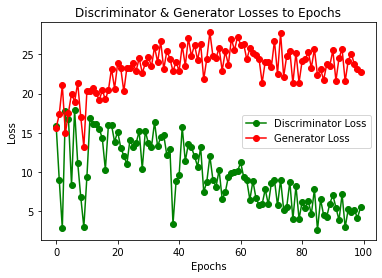

In [7]:
# plotting discriminator loss and generator loss
path = "project/outputs_for_graphs/"
first_filename = "discriminator_v_gan.txt"
second_filename = "generator_v_gan.txt"
graph_title = "Discriminator & Generator Losses to Epochs"
x_title = "Epochs"
y_title = "Loss"
plot_graph(path+first_filename, path+second_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: From the graph we can see that with the progress of the epochs the discriminator is capable of better figuring out "faked" images while the loss of the Generator is staying raughly the same.

**Hypothesis**: It is likely that the network is shallow, but when we try a deeper network it caused vanishing gradient, we saw that the batch normalization helped for that problem but not enough. The fact that the Generator loss stay stable and doesn't improve it's generated images, allows the Discriminator to learn the patterns of the generated images and shrink it's loss with the progress of the epochs. 

first_file lines: [1.2374245917457156, 1.6270784832494738, 1.5205926656525588, 2.1353402110159774, 2.003882652108045, 1.75858956893544, 1.858973764169165, 2.120436446424902, 2.047671431919529, 2.4082082990408336, 2.1517393223069643, 1.2652305457897122, 1.4280292116543392, 1.9048724422474235, 2.133628568456719, 2.5391581734312836, 1.740175953893486, 2.2649026631188716, 2.3453537085482603, 1.461761364551831, 2.494099922593393, 1.8890222924780484, 1.7221761827853228, 2.329157503156652, 2.1138468602826443, 2.3137533346321186, 1.9418513121519143, 2.2798180648091577, 2.1870152338293836, 2.263001058544167, 2.1754724174445155, 2.334048352505834, 2.337662269962622, 2.2535733206624644, 2.2532604886622054, 2.2074802945057157, 2.0672830011072163, 2.020209893190278, 2.172898136962288, 2.0777927116203236, 2.0954992575475604, 2.1486819435850624, 2.211878290524079, 2.103560870889642, 2.066955440800935, 2.1489596274127605, 2.351604643382181, 2.43783280634693, 2.104269074015447, 2.3670301654648513, 2.49

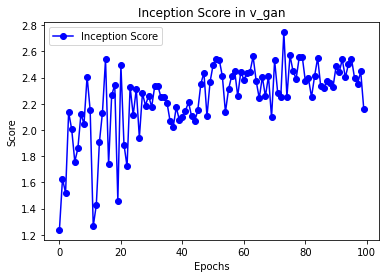

In [8]:
# plotting inception score per epoch
path = "project/outputs_for_graphs/"
first_filename = "inception_v_gan.txt"
graph_title = "Inception Score in v_gan"
x_title = "Epochs"
y_title = "Score"
plot_inception_graph(path+first_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: From the graph we can see an improvment in "inception score" with the progress of the epochs.

**Hypothesis**: This is the kind of behavior we expect to see with the learning process.

In [9]:
import project.spectral_norm_gan as sn_gan
sn_gen = train_gan_model(device, ds_gwb, sn_gan,'sn_gan',sn_gan_hyperparams())
print(sn_gen)

<class 'torch.device'>
{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.2, 'discriminator_optimizer': {'type': 'SGD', 'lr': 0.0075}, 'generator_optimizer': {'type': 'Adam', 'lr': 0.001, 'betas': (0.5, 0.999)}}
<module 'project.spectral_norm_gan' from '/home/topaz.aharon/DL/hw4/project/spectral_norm_gan.py'>
 EPOCH 1/100 
100%|██████████| 17/17 [00:03<00:00,  4.44it/s]
discriminator loss - 1.2975659861284143
generator loss     - 0.9236741381533006
 EPOCH 2/100 
100%|██████████| 17/17 [00:03<00:00,  4.40it/s]
discriminator loss - 1.2729849394629984
generator loss     - 0.8689309253412134
 EPOCH 3/100 
100%|██████████| 17/17 [00:03<00:00,  4.49it/s]
discriminator loss - 1.0787641721613266
generator loss     - 1.0784575273008907
 EPOCH 4/100 
100%|██████████| 17/17 [00:03<00:00,  4.51it/s]
discriminator loss - 1.353452857802896
generator loss     - 0.7969704866409302
 EPOCH 5/100 
100%|██████████| 17/17 [00:03<00:00,  4.58it/s]
discriminator loss - 1.382438764852636
gener

*** Images Generated from best model:


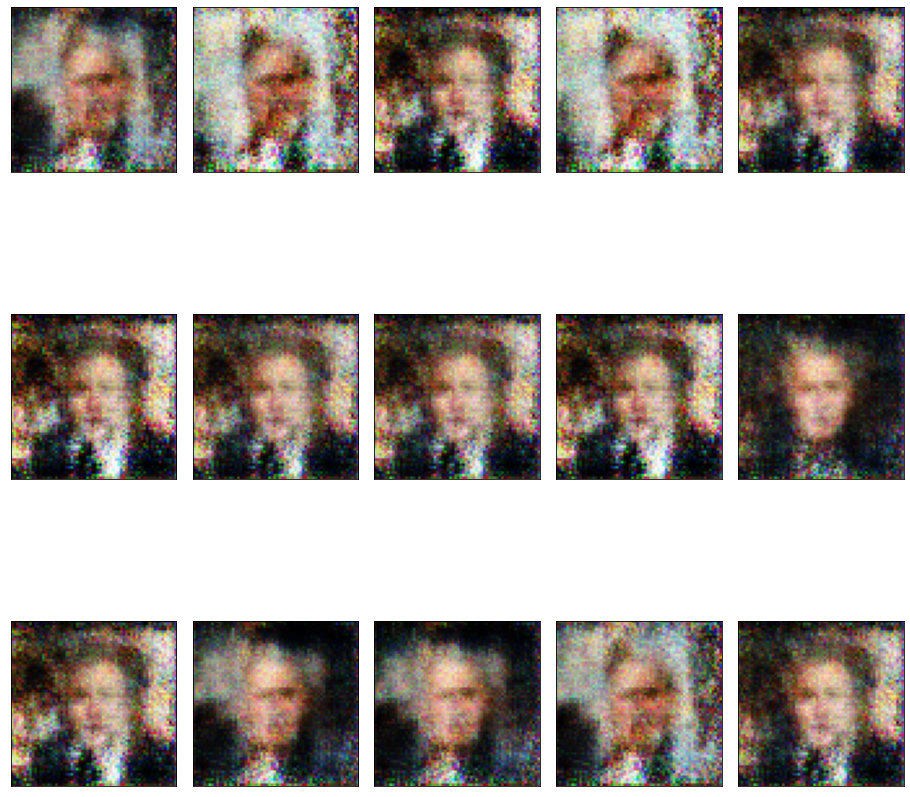

In [10]:
# Plot images from best or last model
checkpoint_file = 'checkpoints/sn_gan'
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(16,16))

first_file lines: [1.2975659861284143, 1.2729849394629984, 1.0787641721613266, 1.353452857802896, 1.382438764852636, 1.4590567841249353, 1.450412715182585, 1.4546394488390755, 1.434987972764408, 1.4272788272184485, 1.4220433305291569, 1.416736834189471, 1.4127225525238936, 1.4112527931437773, 1.4097628102583044, 1.4069646877401016, 1.4030982676674337, 1.4015481542138493, 1.4006118423798506, 1.3994908823686487, 1.401183850624982, 1.399435744566076, 1.3973009726580452, 1.398444701643551, 1.3982009466956644, 1.3962413773817175, 1.3951357532950008, 1.394113863215727, 1.3934091049082138, 1.3953073725980871, 1.3923748591366936, 1.3916651501375086, 1.3959431788500618, 1.3932256137623507, 1.393115807982052, 1.3924281597137451, 1.3927660198772656, 1.392572052338544, 1.3923720051260555, 1.391936750972972, 1.3914442693485933, 1.3916174173355103, 1.39133059277254, 1.3913497854681576, 1.3909610860487993, 1.3907212790320902, 1.3904827202067656, 1.3904283186968636, 1.3902715164072372, 1.3901172525742

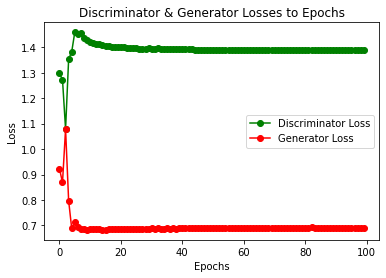

In [11]:
# plotting discriminator loss and generator loss
path = "project/outputs_for_graphs/"
first_filename = "discriminator_sn_gan.txt"
second_filename = "generator_sn_gan.txt"
graph_title = "Discriminator & Generator Losses to Epochs"
x_title = "Epochs"
y_title = "Loss"
plot_graph(path+first_filename, path+second_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: From the graph we can see that the Discriminator loss is higher. Furthermore, we can notice a big improvment in the loss values in comparison to the loss values of the vanilla gan model.

**Hypothesis**: The reason to those results might be that the Generator is capabale of "tricking" the Discriminator. The consistency in loss values might refer to the fact that the Discriminator didn't learn the "fake" patterns and keep recognizing them as "real" images. We also believe that in our case, although we have an improvment in loss values in comparison to the vanilla gan model, still the Spectral Norm had some negative effect on the Discriminator (in the next inception score plot, we can see a support for this claim) . Maybe we could better utilize the hyperparameters and choose a better architecture for the Spectral Norm uses.

first_file lines: [1.3110828380524473, 2.061800400705777, 1.985868441495943, 1.5636200430903173, 2.0302645246645117, 1.7280986842727517, 1.6220514402891988, 1.9071004371473648, 1.5539821638438842, 1.5422161917007928, 1.4045388948930215, 1.4987397531220354, 1.674307674681152, 1.6411112654074476, 1.5289094028597414, 1.5387635175013292, 1.7540924957767803, 1.4783025759232735, 1.4757048131416417, 1.4507751120340397, 1.368285979040689, 1.3183063731105393, 1.4176410850036139, 1.471133921665494, 1.3305829079400682, 1.518256905207581, 1.4081754169501552, 1.337448513039208, 1.4533378201531628, 1.3474214240770859, 1.6482354489631135, 1.681451375077955, 1.4962437184221347, 1.680404394522848, 1.7177442459694585, 1.583932564556632, 1.46271582438146, 1.651081628223714, 2.0265544567088742, 2.0309681594004965, 1.944030708945663, 1.7640501998849103, 1.8606989178964668, 1.9168527214556523, 1.9832136084946743, 2.318492897055259, 2.159417901219837, 2.0443030961200983, 2.186727789828466, 1.9586442416579506

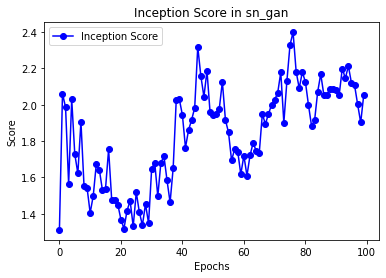

In [12]:
# plotting inception score per epoch
path = "project/outputs_for_graphs/"
first_filename = "inception_sn_gan.txt"
graph_title = "Inception Score in sn_gan"
x_title = "Epochs"
y_title = "Score"
plot_inception_graph(path+first_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: From the graph we can see that the Inception Score arises with epochs

**Hypothesis**: The Discriminator loss (in abs values) is twice the size of the Generator loss, this probably one of the reasons allowing a constant improvment in the generated images.The "level" of images generated by the Generator is improved with time(epochs). This is the kind of behaviour we wish in a learning process.

In [13]:
import project.wass_gan as w_gan
w_gen = train_gan_model(device, ds_gwb, w_gan,'w_gan',w_gan_hyperparams())

<class 'torch.device'>
{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.0002, 'discriminator_optimizer': {'type': 'RMSprop', 'lr': 3.5e-05}, 'generator_optimizer': {'type': 'RMSprop', 'lr': 0.0001}, 'N': 5}
<module 'project.wass_gan' from '/home/topaz.aharon/DL/hw4/project/wass_gan.py'>
 EPOCH 1/100 
100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
discriminator loss - -0.21327508328592076
generator loss     - -0.2853653990827939
 EPOCH 2/100 
100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
discriminator loss - -0.3897333092549268
generator loss     - -0.44678080607863035
 EPOCH 3/100 
100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
discriminator loss - -0.49101362859501557
generator loss     - -0.1724680838010767
 EPOCH 4/100 
100%|██████████| 17/17 [00:08<00:00,  1.97it/s]
discriminator loss - -0.5504626105813419
generator loss     - 0.0920445716337246
 EPOCH 5/100 
100%|██████████| 17/17 [00:08<00:00,  1.96it/s]
discriminator loss - -0.6531153391389286
generator los

*** Images Generated from best model:


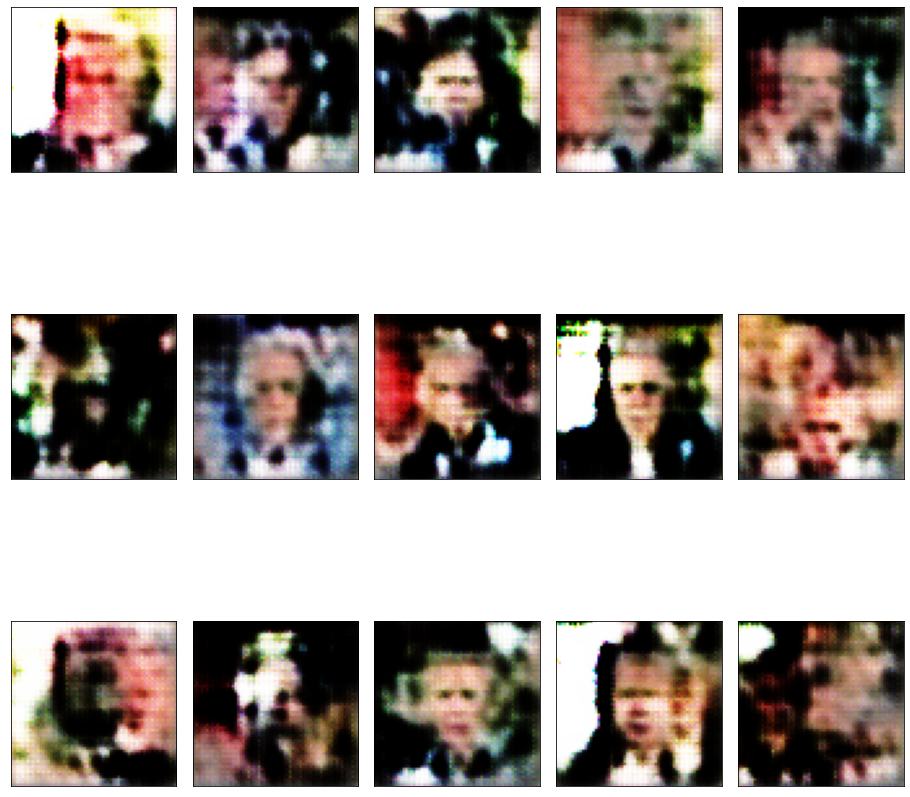

In [14]:
# Plotting images from best or last model
checkpoint_file = 'checkpoints/w_gan'
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(16,16))

first_file lines: [-0.21327508328592076, -0.3897333092549268, -0.49101362859501557, -0.5504626105813419, -0.6531153391389286, -0.614269544096554, -0.655881462728276, -0.673295152537963, -0.719629729495329, -0.6353338045232436, -0.6988590605118695, -0.6758677258211023, -0.7396075900863198, -0.7479529696352342, -0.7763026882620419, -0.7743784995640025, -0.6452194951912936, -0.6917198721100303, -0.7106832844369552, -0.7446663362138412, -0.7226895444533404, -0.7820407082052792, -0.7857679654570187, -0.7876422861043144, -0.7880033850669861, -0.7876755560145658, -0.7238682455876294, -0.7724756843903485, -0.786760035683127, -0.7847506894784815, -0.7482534962541917, -0.7206571093376946, -0.6232002263560015, -0.72494897071053, -0.6929318414014929, -0.7694794325267568, -0.6953544774476219, -0.7789994197733262, -0.7891598413972294, -0.7906240750761593, -0.7915723814683802, -0.7919637806275311, -0.7921020493787878, -0.7919726617196027, -0.7780742680325228, -0.6478900488685159, -0.7905377079458797,

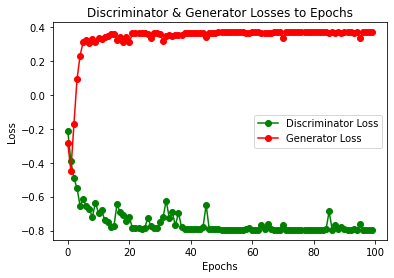

In [15]:
# plotting discriminator loss and generator loss
path = "project/outputs_for_graphs/"
first_filename = "discriminator_w_gan.txt"
second_filename = "generator_w_gan.txt"
graph_title = "Discriminator & Generator Losses to Epochs"
x_title = "Epochs"
y_title = "Loss"
plot_graph(path+first_filename, path+second_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: From the graph we can see that the Discriminator loss is higher (in absolute values). Furthermore, we can notice a big improvment in the loss values in comparison to the loss values of both the vanilla gan model and the spectral normalization gan model.

**Hypothesis**: The reason to those results might be that the Generator is capabale of "tricking" the Discriminator. The consistency in loss values might refer to the fact that the Discriminator didn't learn the "fake" patterns and keep recognizing them as "real" images.

first_file lines: [1.842659117717792, 2.250785604745277, 2.124391202578428, 2.0478745073280034, 2.3228469287179356, 2.0633487658520377, 2.0401452534169304, 2.280351664274859, 2.1358347302443637, 1.8868036865087114, 1.9020670498866303, 1.87217221586074, 1.9507352398905335, 2.2712371338111987, 2.259281795164224, 2.0916943900194847, 1.828679053796115, 1.9954416022108623, 1.7781491352200958, 1.739924325769822, 1.9814376195983, 2.061532835070979, 2.0398850161891704, 2.0620818299306447, 2.062777037867534, 2.0885272194024656, 1.9521927247474353, 2.084771050745773, 1.8206706842989475, 1.9258515640835092, 2.161275658959849, 1.903489023825215, 2.0463312715801916, 2.2479046783853893, 2.2179471902990553, 2.2480278771202786, 2.4475802452012347, 2.1683866386460178, 2.0322999935255215, 2.093089036637677, 2.0867315043291006, 2.260017427574266, 2.157336634751681, 2.272581013854805, 2.4057131697882967, 2.1378926775937637, 2.067300697590963, 2.0150694767358073, 2.0720453269677797, 1.9823764006769449, 2.1

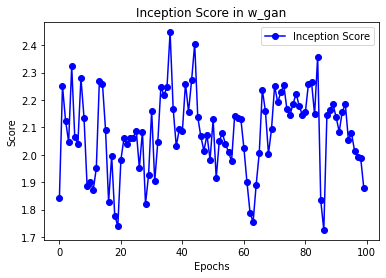

In [16]:
# plotting inception score per epoch
path = "project/outputs_for_graphs/"
first_filename = "inception_w_gan.txt"
graph_title = "Inception Score in w_gan"
x_title = "Epochs"
y_title = "Score"
plot_inception_graph(path+first_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: From the graph we can't see a solid improvment graph, still relatively good results for the "George Bush" images.

**Hypothesis**: This might happen due to the fact that the wass gan improvment has a really good starting point with low loss values. Therefore, allowing a quick learning process. 

In [17]:
import project.spectral_norm_wass_gan as sn_w_gan
sn_plus_w_gen = train_gan_model(device, ds_gwb, sn_w_gan,'sn_w_gan',w_gan_hyperparams())

<class 'torch.device'>
{'batch_size': 32, 'z_dim': 128, 'data_label': 1, 'label_noise': 0.0002, 'discriminator_optimizer': {'type': 'RMSprop', 'lr': 3.5e-05}, 'generator_optimizer': {'type': 'RMSprop', 'lr': 0.0001}, 'N': 5}
<module 'project.spectral_norm_wass_gan' from '/home/topaz.aharon/DL/hw4/project/spectral_norm_wass_gan.py'>
 EPOCH 1/100 
100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
discriminator loss - -326.39489835851333
generator loss     - 262.64460372924805
 EPOCH 2/100 
100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
discriminator loss - -132.5127114688649
generator loss     - 54.81978977427763
 EPOCH 3/100 
100%|██████████| 17/17 [00:08<00:00,  1.90it/s]
discriminator loss - -109.24625037698185
generator loss     - 53.937753943835986
 EPOCH 4/100 
100%|██████████| 17/17 [00:08<00:00,  1.89it/s]
discriminator loss - -103.97546162324794
generator loss     - 98.0758368548225
 EPOCH 5/100 
100%|██████████| 17/17 [00:09<00:00,  1.88it/s]
discriminator loss - -132.4617574355

*** Images Generated from best model:


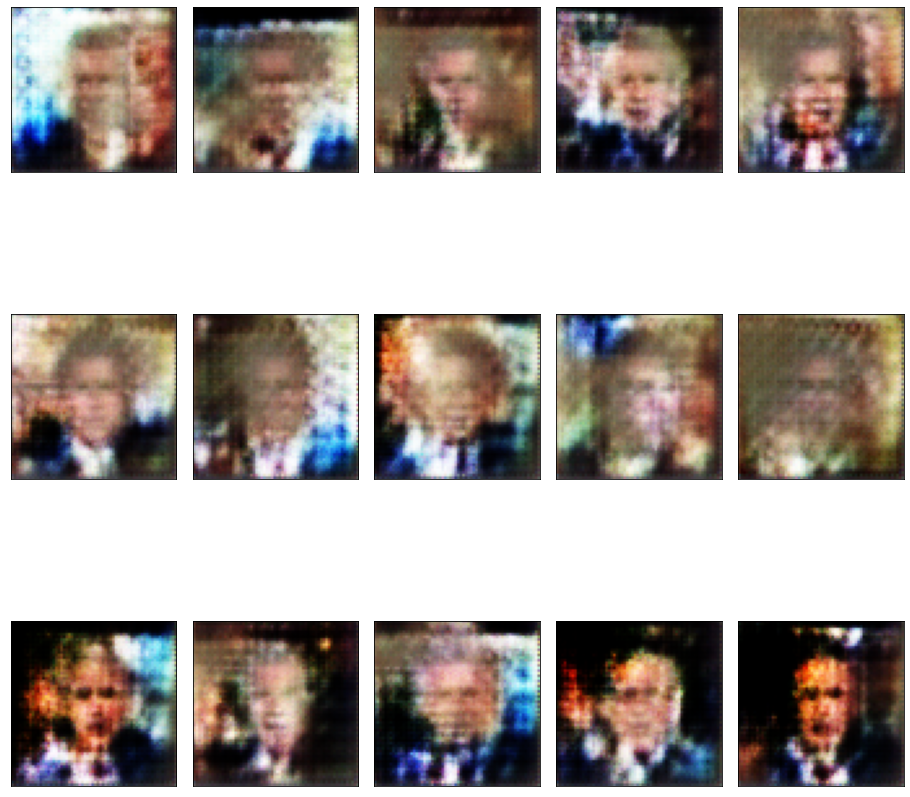

In [18]:
# Plotting images from best or last model
checkpoint_file = 'checkpoints/sn_w_gan'
if os.path.isfile(f'{checkpoint_file}.pt'):
    gen = torch.load(f'{checkpoint_file}.pt', map_location=device)
print('*** Images Generated from best model:')
samples = gen.sample(n=15, with_grad=False).cpu()
fig, _ = plot.tensors_as_images(samples, nrows=3, figsize=(16,16))

first_file lines: [-326.39489835851333, -132.5127114688649, -109.24625037698185, -103.97546162324794, -132.46175743551817, -114.11176479563994, -106.56801066679112, -98.03035668765797, -90.38837634815889, -91.73624846514534, -83.89673390107997, -83.7633311327766, -92.83745193481445, -93.3366849562701, -86.97446778241326, -86.19844773236443, -84.38207155115464, -87.99139135024127, -87.7036938386805, -81.6537140116972, -87.11641625797047, -76.63188350901885, -93.52167017319623, -64.79581316779641, -88.01450673271628, -74.74757250617532, -77.68078119614545, -74.04974634507123, -74.18129505830653, -77.84883611342487, -69.12655045004452, -67.23796709846047, -67.29478196536793, -76.90914827234604, -72.7746914134306, -68.99438801933738, -79.49491377437816, -58.29657117058249, -75.33399200439453, -65.51290495255414, -66.23346485811122, -75.17700823615579, -70.10938453674316, -59.163143157958984, -69.9181911244112, -65.14635680703556, -68.70728189804974, -76.5475154764512, -54.362114401424634, 

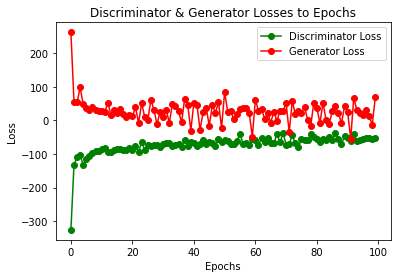

In [19]:
# plotting discriminator loss and generator loss
path = "project/outputs_for_graphs/"
first_filename = "discriminator_sn_w_gan.txt"
second_filename = "generator_sn_w_gan.txt"
graph_title = "Discriminator & Generator Losses to Epochs"
x_title = "Epochs"
y_title = "Loss"
plot_graph(path+first_filename, path+second_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: We can notice a significant improvment with the progress of the epochs in both the Discriminator and Generator losses tends towards zero. 

**Hypothesis**: This is happening due to the contribution of the two (spectral and wass togather) and fast learning. Hyperparameter has a direct effect on the starting point values of the loss.

first_file lines: [1.8094318200511283, 1.6005615241383016, 1.865974699120578, 1.9421874708803117, 2.0582880940480552, 1.8544265119254246, 1.7126565031370808, 1.69426243287249, 1.635206459139407, 1.632539511573696, 1.7122647270971847, 1.6859470905472336, 1.7054966507212024, 1.7958194234487206, 1.792154730244181, 1.8251088561752653, 1.7119439855190994, 1.7591416837449543, 1.659395192568698, 1.731698518012409, 1.6850576313763936, 1.5996926489562766, 1.6754990949850053, 1.554225921925939, 1.648490504227693, 1.5929194188439417, 1.5978195398156756, 1.5576123960138222, 1.728449611982122, 1.6182116295318483, 1.6474997182114688, 1.6194491419747914, 1.8787763095034689, 1.5531502296790127, 1.6041162313551292, 1.6051149429812541, 1.7162011864468347, 1.626725259824222, 1.6029980616135286, 1.5747107097379687, 1.5788045243083895, 1.6991106910718683, 1.5722087698263763, 1.7238270542387202, 1.6291326915949234, 1.5803883080024752, 1.7128635087710808, 1.572240467494708, 1.584511540635684, 1.6959814774259

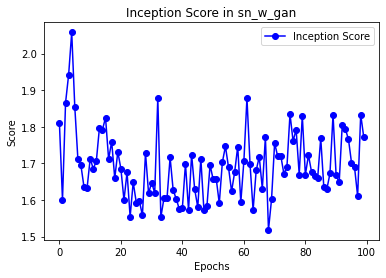

In [20]:
# plotting inception score per epoch
path = "project/outputs_for_graphs/"
first_filename = "inception_sn_w_gan.txt"
graph_title = "Inception Score in sn_w_gan"
x_title = "Epochs"
y_title = "Score"
plot_inception_graph(path+first_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: TODO

**Hypothesis**: TODO

first_file lines: [1.2374245917457156, 1.6270784832494738, 1.5205926656525588, 2.1353402110159774, 2.003882652108045, 1.75858956893544, 1.858973764169165, 2.120436446424902, 2.047671431919529, 2.4082082990408336, 2.1517393223069643, 1.2652305457897122, 1.4280292116543392, 1.9048724422474235, 2.133628568456719, 2.5391581734312836, 1.740175953893486, 2.2649026631188716, 2.3453537085482603, 1.461761364551831, 2.494099922593393, 1.8890222924780484, 1.7221761827853228, 2.329157503156652, 2.1138468602826443, 2.3137533346321186, 1.9418513121519143, 2.2798180648091577, 2.1870152338293836, 2.263001058544167, 2.1754724174445155, 2.334048352505834, 2.337662269962622, 2.2535733206624644, 2.2532604886622054, 2.2074802945057157, 2.0672830011072163, 2.020209893190278, 2.172898136962288, 2.0777927116203236, 2.0954992575475604, 2.1486819435850624, 2.211878290524079, 2.103560870889642, 2.066955440800935, 2.1489596274127605, 2.351604643382181, 2.43783280634693, 2.104269074015447, 2.3670301654648513, 2.49

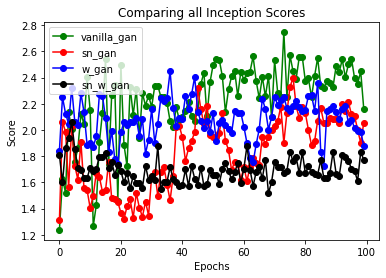

In [21]:
# plotting a graph comparing all inception scores
path = "project/outputs_for_graphs/"
first_filename =  "inception_v_gan.txt"
second_filename =  "inception_sn_gan.txt"
third_filename =  "inception_w_gan.txt"
forth_filename =  "inception_sn_w_gan.txt"
graph_title = "Comparing all Inception Scores"
x_title = "Epochs"
y_title = "Score"
plot_all_inceptions_graph(path+first_filename, path+second_filename, path+third_filename, path+forth_filename, graph_title, x_title, y_title)

**Results Analysis**

**Observation**: TODO

**Hypothesis**: TODO